In [5]:
import h5py as h5

datadir = '../../dataset/optimization'
figuredir = '../../figure/intensity/optimization'

os.makedirs(figuredir, exist_ok=True)

In [34]:
runs = {}

for filename in os.listdir(datadir):
    key = filename.split('.')[0]
    
    if key not in runs:
        runs[key] = {}
    run = runs[key]
    
    with h5.File(os.path.join(datadir, filename), 'r') as file:
        for k in list(file.keys()):
            if '@' in k:
                k = k.split('-')
                A = int(k[0].split('@')[-1])
                i = int(k[1].split('@')[-1])
                 
                if A not in run:
                    run[A] = []
                run[A].append(i)
            
            else:
                A = int(k.split('amplitude')[1])

                for k in file[k].keys():                    
                    if '@' in k:
                        i = int(k.split('@')[-1])
                    else:
                        i = int(k.split('iteration')[1])


                    if A not in run:
                        run[A] = []
                    run[A].append(i)
                    
runs

{'1200mV-32': {0: [0, 63],
  1: [0, 1, 19, 32, 37, 4, 5],
  10: [0, 1, 100, 15, 4],
  11: [0, 137, 158, 17, 201, 202, 217, 278, 352, 481, 8],
  12: [0, 1, 14, 2, 418],
  13: [0,
   130,
   165,
   17,
   192,
   2,
   237,
   238,
   351,
   355,
   395,
   407,
   411,
   427,
   479,
   55,
   6,
   9],
  14: [0, 1, 355, 7],
  15: [0, 1, 157, 203, 238, 282, 292, 446, 491, 50],
  16: [0, 1, 86],
  17: [0, 100, 152, 165, 22, 240, 251, 284, 335, 375, 382, 426, 485, 487, 51],
  18: [0, 10, 26],
  19: [0, 1, 2, 20, 5, 57, 89],
  2: [0, 1, 163, 46, 52, 60],
  20: [0, 162, 2, 3],
  21: [0, 1, 156, 3, 6],
  22: [0, 1, 113, 357, 64],
  23: [0, 216, 27, 28, 9],
  24: [0, 1, 159, 2],
  25: [0, 1, 12, 136, 14, 17, 232, 326, 368],
  26: [0, 1, 15, 18, 184, 193, 24, 277, 47],
  27: [0, 1, 350, 4, 42, 5, 53],
  28: [0, 162, 166, 18, 185, 213, 233, 242, 333, 414, 56, 63, 71],
  29: [0, 1, 2, 4, 415],
  3: [0, 28, 36, 65, 75, 8],
  30: [0,
   103,
   170,
   176,
   198,
   27,
   271,
   272,
   282

In [65]:
def read(filename, dataset):
    df = pd.read_hdf(os.path.join(datadir, filename), dataset)
    df['frequency'] = 80e6 + 40e6 * df.time / df.time.max()
    
    return df

def read_final(filename):
    key = filename.split('.')[0]

    An = max(runs[key].keys())
    n = max(runs[key][An])
    
    try:
        return read(filename, f'amplitude{An}/iteration{n}')
    except KeyError:
        try:
            return read(filename, f'amplitude@{An}-iteration@{n}')
        except KeyError:
            return read(filename, f'amplitude{An}/iteration@{n}')

In [68]:
final32_1200 = read_final('1200mV-32.h5')
final32_1000 = read_final('1000mV-32.h5')
final32_0800 = read_final('800mV-32.h5')

final16_1200 = read_final('1200mV-16.h5')
final16_1000 = read_final('1000mV-16.h5')
final16_0800 = read_final('800mV-16.h5')

final8_1200 = read_final('1200mV-8.h5')
final8_1000 = read_final('1000mV-8.h5')
final8_0800 = read_final('800mV-8.h5')

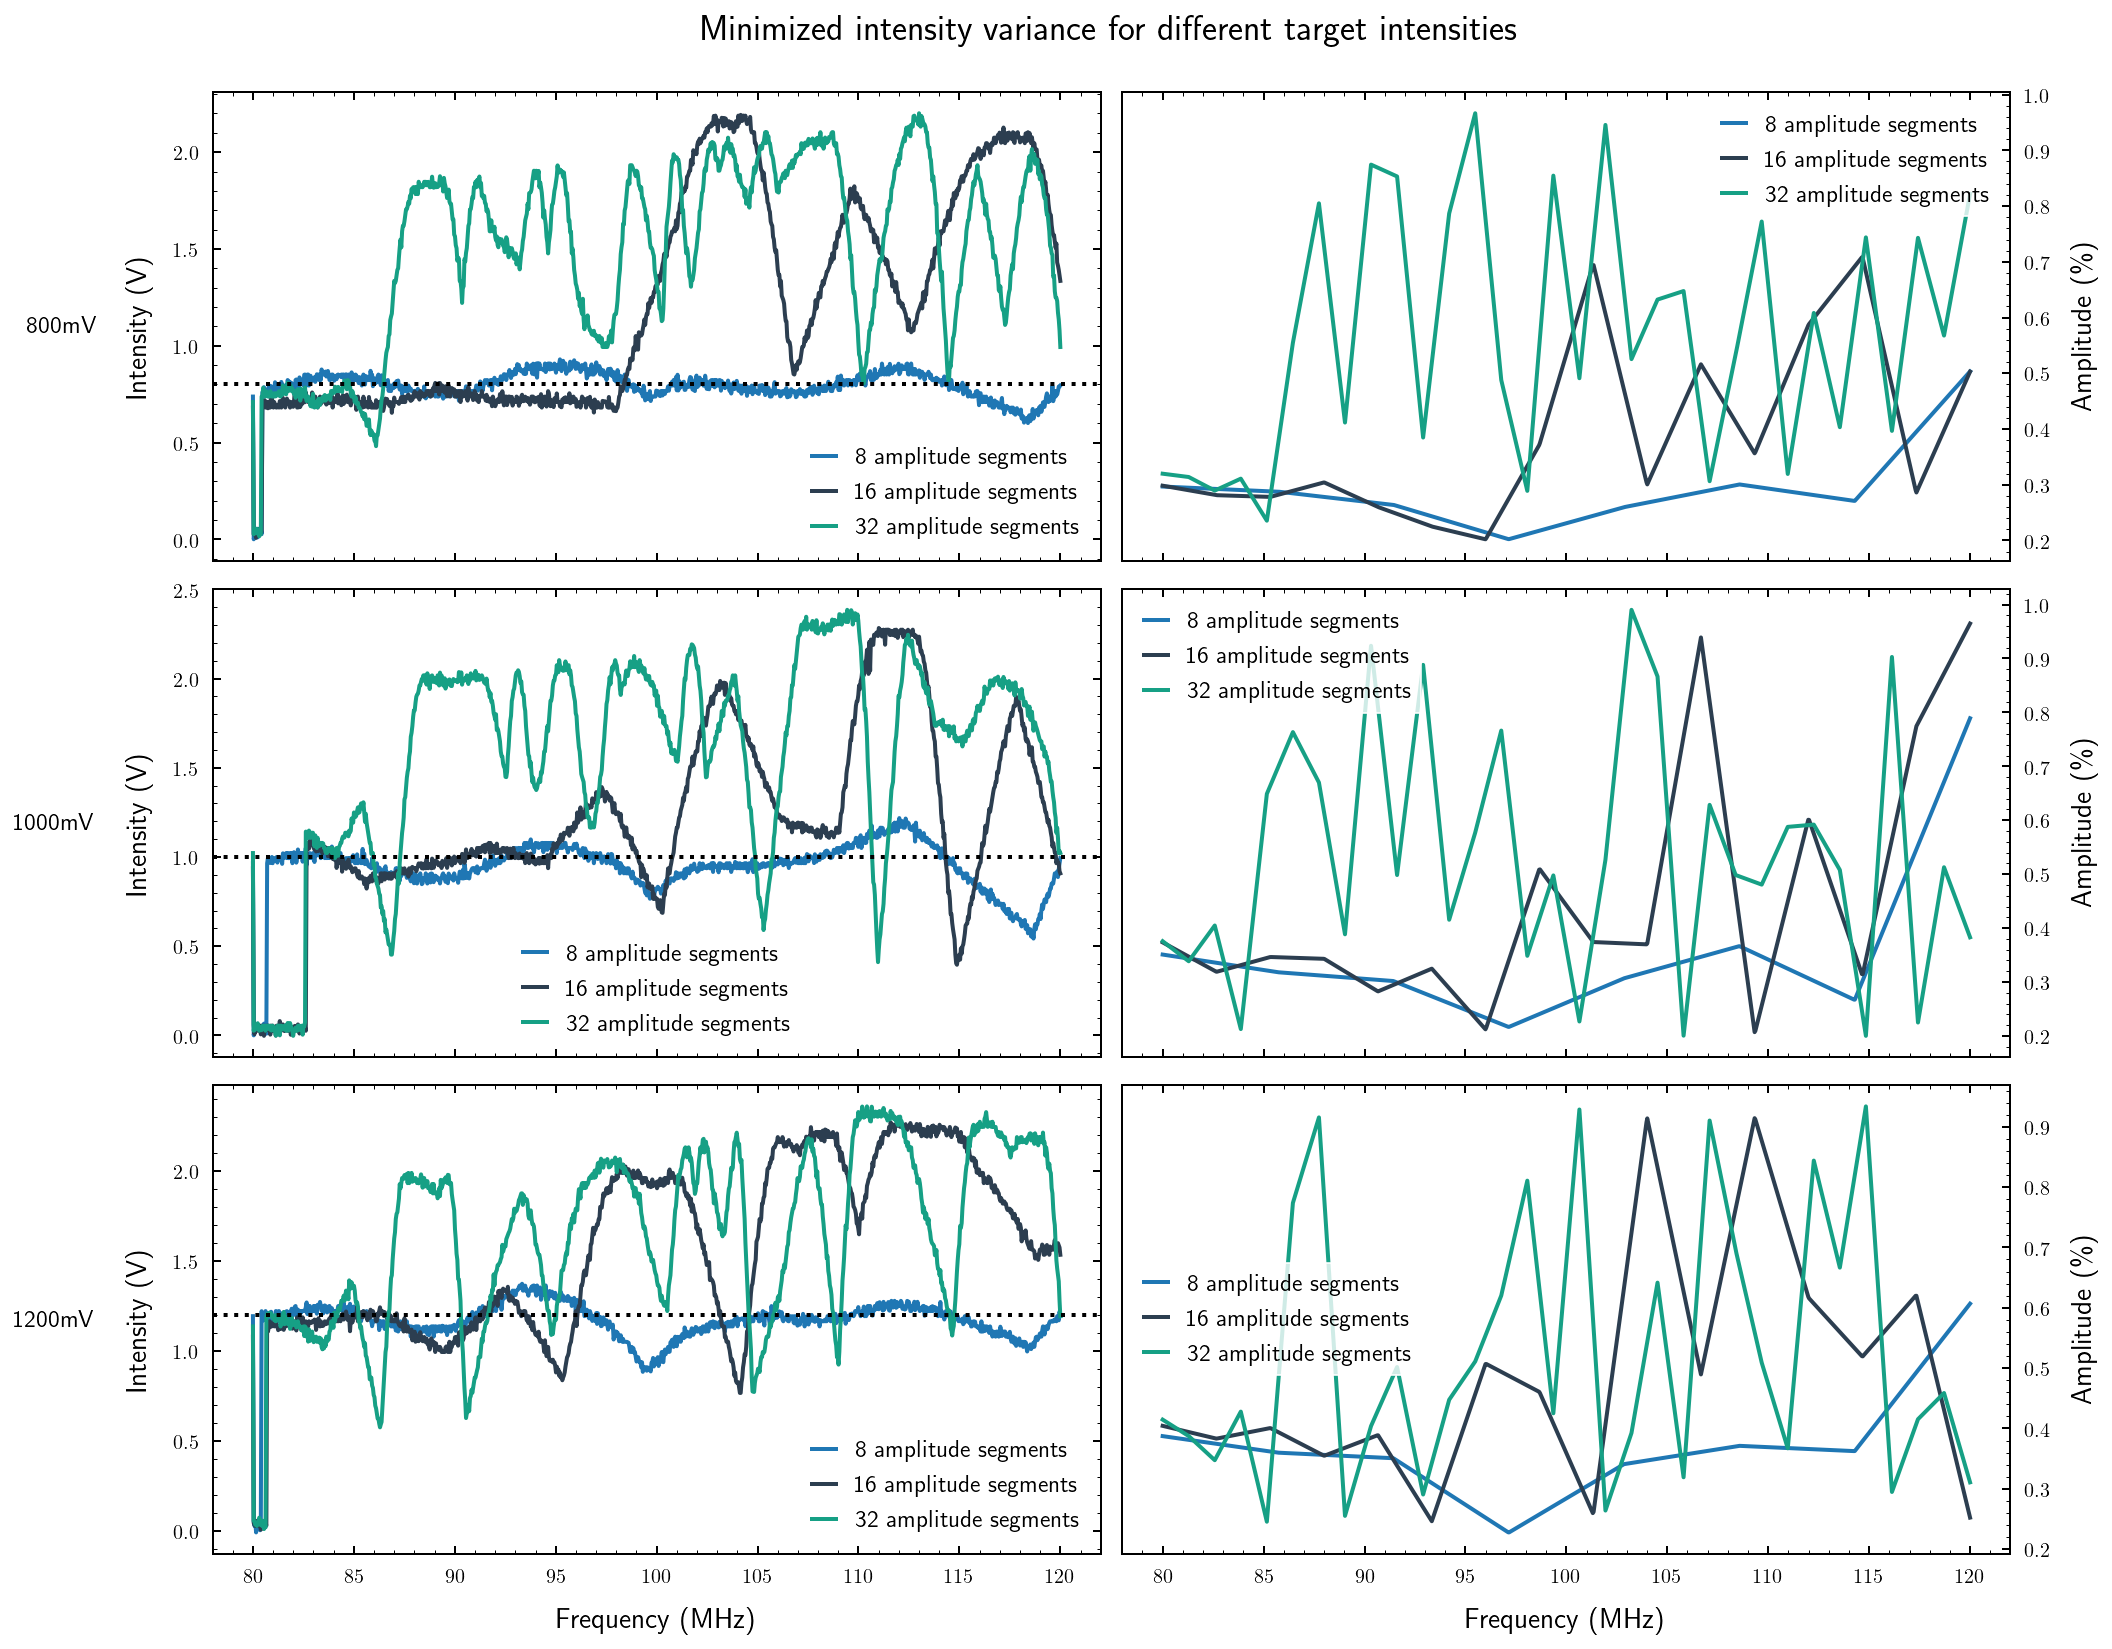

In [170]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 12), sharex=True)

fig.suptitle('Minimized intensity variance for different target intensities')

axes[0][0].plot(final8_0800.frequency / 1e6, final8_0800.voltage, label='8 amplitude segments')
axes[0][0].plot(final16_0800.frequency / 1e6, final16_0800.voltage, label='16 amplitude segments', color='#2c3e50')
axes[0][0].plot(final32_0800.frequency / 1e6, final32_0800.voltage, label='32 amplitude segments', color='#16a085')
axes[0][0].set_ylabel('Intensity (V)')
axes[0][0].axhline(.8, color='black', linestyle='dotted')
axes[0][0].legend()

axes[0][1].plot(final8_0800.frequency / 1e6, final8_0800.amplitude, label='8 amplitude segments')
axes[0][1].plot(final16_0800.frequency / 1e6, final16_0800.amplitude, label='16 amplitude segments', color='#2c3e50')
axes[0][1].plot(final32_0800.frequency / 1e6, final32_0800.amplitude, label='32 amplitude segments', color='#16a085')
axes[0][1].yaxis.tick_right()
axes[0][1].yaxis.set_label_position("right")
axes[0][1].set_ylabel('Amplitude (\%)')
axes[0][1].legend()

axes[1][0].plot(final8_1000.frequency / 1e6, final8_1000.voltage, label='8 amplitude segments')
axes[1][0].plot(final16_1000.frequency / 1e6, final16_1000.voltage, label='16 amplitude segments', color='#2c3e50')
axes[1][0].plot(final32_1000.frequency / 1e6, final32_1000.voltage, label='32 amplitude segments', color='#16a085')
axes[1][0].set_ylabel('Intensity (V)')
axes[1][0].axhline(1, color='black', linestyle='dotted')
axes[1][0].legend()

axes[1][1].plot(final8_1000.frequency / 1e6, final8_1000.amplitude, label='8 amplitude segments')
axes[1][1].plot(final16_1000.frequency / 1e6, final16_1000.amplitude, label='16 amplitude segments', color='#2c3e50')
axes[1][1].plot(final32_1000.frequency / 1e6, final32_1000.amplitude, label='32 amplitude segments', color='#16a085')
axes[1][1].yaxis.tick_right()
axes[1][1].yaxis.set_label_position("right")
axes[1][1].set_ylabel('Amplitude (\%)')
axes[1][1].legend()

axes[2][0].plot(final8_1200.frequency / 1e6, final8_1200.voltage, label='8 amplitude segments')
axes[2][0].plot(final16_1200.frequency / 1e6, final16_1200.voltage, label='16 amplitude segments', color='#2c3e50')
axes[2][0].plot(final32_1200.frequency / 1e6, final32_1200.voltage, label='32 amplitude segments', color='#16a085')
axes[2][0].set_xlabel('Frequency (MHz)')
axes[2][0].set_ylabel('Intensity (V)')
axes[2][0].axhline(1.2, color='black', linestyle='dotted')
axes[2][0].legend()

axes[2][1].plot(final8_1200.frequency / 1e6, final8_1200.amplitude, label='8 amplitude segments')
axes[2][1].plot(final16_1200.frequency / 1e6, final16_1200.amplitude, label='16 amplitude segments', color='#2c3e50')
axes[2][1].plot(final32_1200.frequency / 1e6, final32_1200.amplitude, label='32 amplitude segments', color='#16a085')
axes[2][1].set_xlabel('Frequency (MHz)')
axes[2][1].yaxis.tick_right()
axes[2][1].yaxis.set_label_position("right")
axes[2][1].set_ylabel('Amplitude (\%)')
axes[2][1].legend()

pad = 5
cols = ['Intensity', 'Amplitude']
rows = ['800mV', '1000mV', '1200mV']

#for ax, col in zip(axes[0], cols):
#    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                xycoords='axes fraction', textcoords='offset points',
#                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(figuredir, 'overview.pdf'))
plt.show()

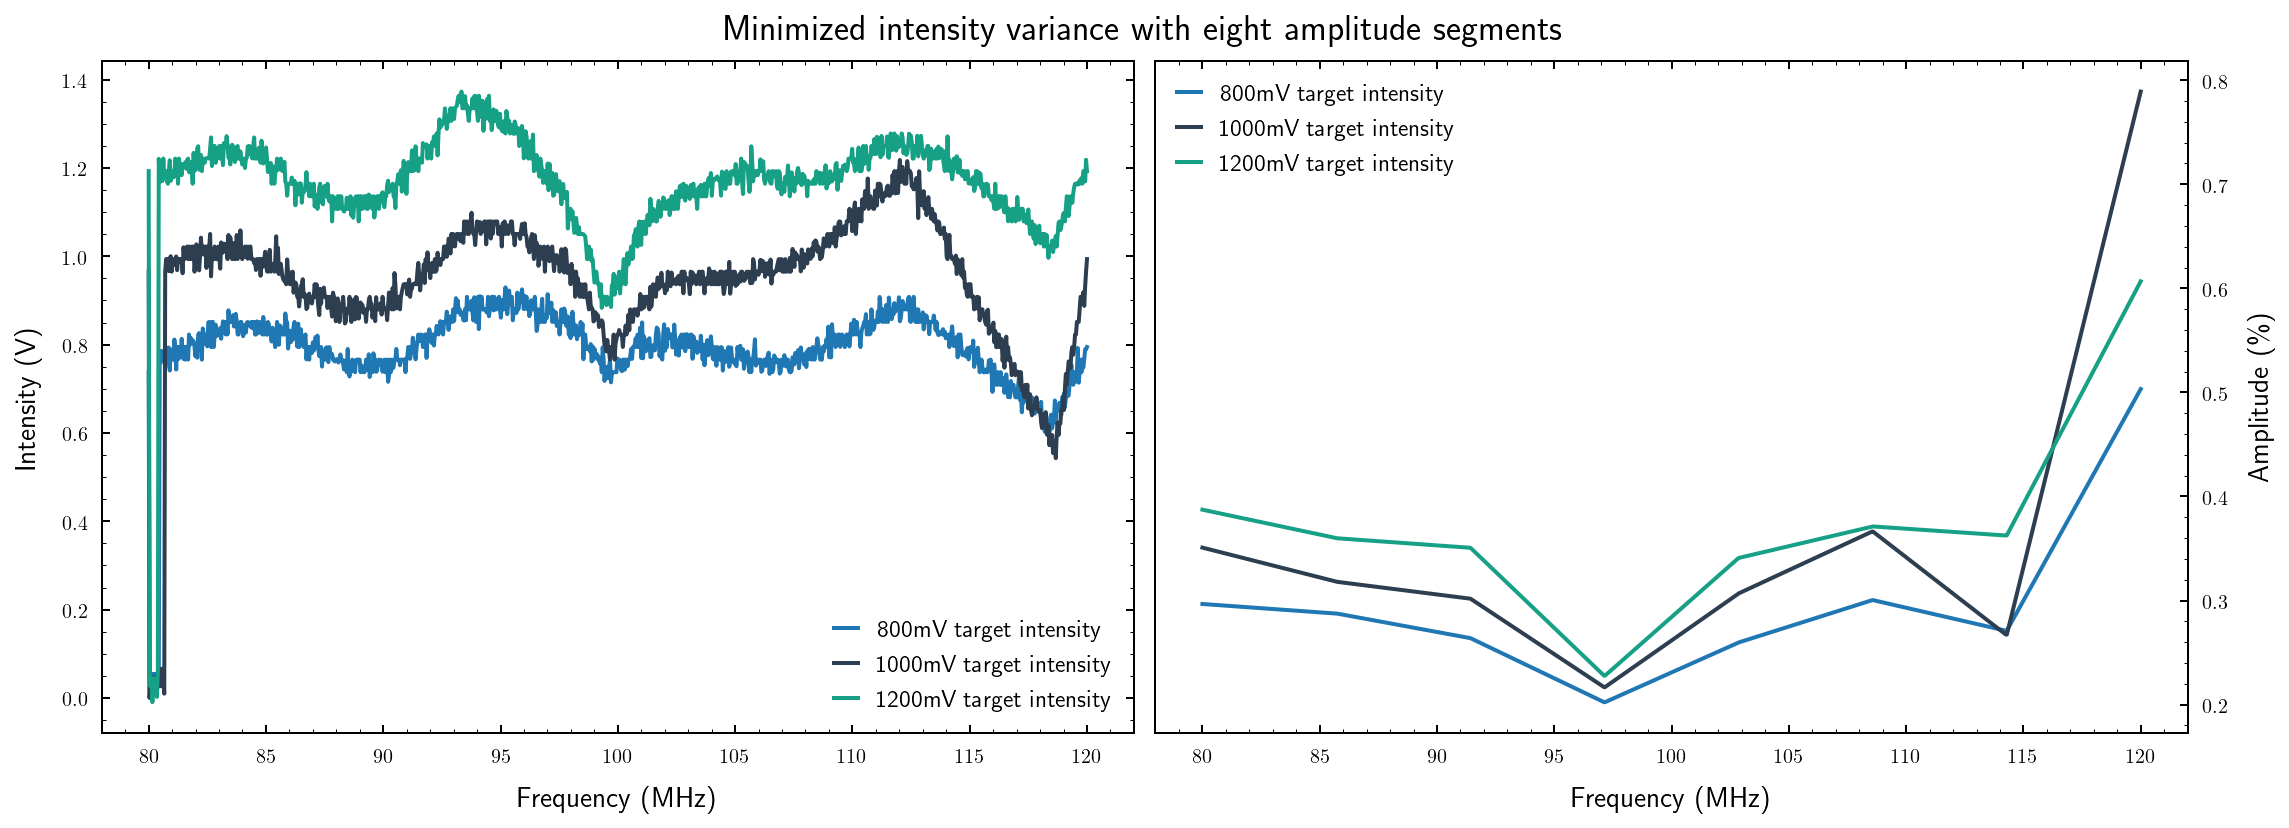

In [120]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

fig.suptitle('Minimized intensity variance with eight amplitude segments')

axes[0].plot(final8_0800.frequency / 1e6, final8_0800.voltage, label='800mV target intensity')
axes[0].plot(final8_1000.frequency / 1e6, final8_1000.voltage, label='1000mV target intensity', color='#2c3e50')
axes[0].plot(final8_1200.frequency / 1e6, final8_1200.voltage, label='1200mV target intensity', color='#16a085')
axes[0].set_ylabel('Intensity (V)')
axes[0].set_xlabel('Frequency (MHz)')
axes[0].legend()

axes[1].plot(final8_0800.frequency / 1e6, final8_0800.amplitude, label='800mV target intensity')
axes[1].plot(final8_1000.frequency / 1e6, final8_1000.amplitude, label='1000mV target intensity', color='#2c3e50')
axes[1].plot(final8_1200.frequency / 1e6, final8_1200.amplitude, label='1200mV target intensity', color='#16a085')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel('Amplitude (\%)')
axes[1].set_xlabel('Frequency (MHz)')
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(os.path.join(figuredir, 'intensity-amplitude.pdf'))
plt.show()

In [84]:
runs['800mV-8']

{0: [0, 1, 14, 3, 87, 96],
 1: [0, 1, 2, 221, 395, 7, 87],
 2: [0, 1, 18, 225, 28, 7, 96],
 3: [0, 1, 151, 44, 5],
 4: [0, 1, 124, 15, 16, 2, 3, 39, 4],
 5: [0, 10, 108, 2, 257, 27, 4],
 6: [0, 15, 18, 19, 2, 3, 36, 4, 99],
 7: [0, 12, 13, 3]}

In [135]:
A0n0 = read('800mV-8.h5', 'amplitude0/iteration0')
A0n1 = read('800mV-8.h5', 'amplitude0/iteration1')
A0n14 = read('800mV-8.h5', 'amplitude0/iteration14')
A0n96 = read('800mV-8.h5', 'amplitude0/iteration96')

A1n0 = read('800mV-8.h5', 'amplitude1/iteration0')
A1n1 = read('800mV-8.h5', 'amplitude1/iteration1')
A1n87 = read('800mV-8.h5', 'amplitude1/iteration87')
A1n395 = read('800mV-8.h5', 'amplitude1/iteration395')

A2n0 = read('800mV-8.h5', 'amplitude2/iteration0')
A2n1 = read('800mV-8.h5', 'amplitude2/iteration1')
A2n96 = read('800mV-8.h5', 'amplitude2/iteration96')
A2n225 = read('800mV-8.h5', 'amplitude2/iteration225')

A3n0 = read('800mV-8.h5', 'amplitude3/iteration0')
A3n1 = read('800mV-8.h5', 'amplitude3/iteration1')
A3n44 = read('800mV-8.h5', 'amplitude3/iteration44')
A3n151 = read('800mV-8.h5', 'amplitude3/iteration151')

A4n0 = read('800mV-8.h5', 'amplitude4/iteration0')
A4n1 = read('800mV-8.h5', 'amplitude4/iteration1')
A4n39 = read('800mV-8.h5', 'amplitude4/iteration39')
A4n124 = read('800mV-8.h5', 'amplitude4/iteration124')

A5n0 = read('800mV-8.h5', 'amplitude5/iteration0')
A5n1 = read('800mV-8.h5', 'amplitude5/iteration2')
A5n108 = read('800mV-8.h5', 'amplitude5/iteration108')
A5n257 = read('800mV-8.h5', 'amplitude5/iteration257')

A6n0 = read('800mV-8.h5', 'amplitude6/iteration0')
A6n1 = read('800mV-8.h5', 'amplitude6/iteration2')
A6n19 = read('800mV-8.h5', 'amplitude6/iteration19')
A6n99 = read('800mV-8.h5', 'amplitude6/iteration99')

A7n0 = read('800mV-8.h5', 'amplitude7/iteration0')
A7n1 = read('800mV-8.h5', 'amplitude7/iteration3')
A7n3 = read('800mV-8.h5', 'amplitude7/iteration12')
A7n13 = read('800mV-8.h5', 'amplitude7/iteration13')

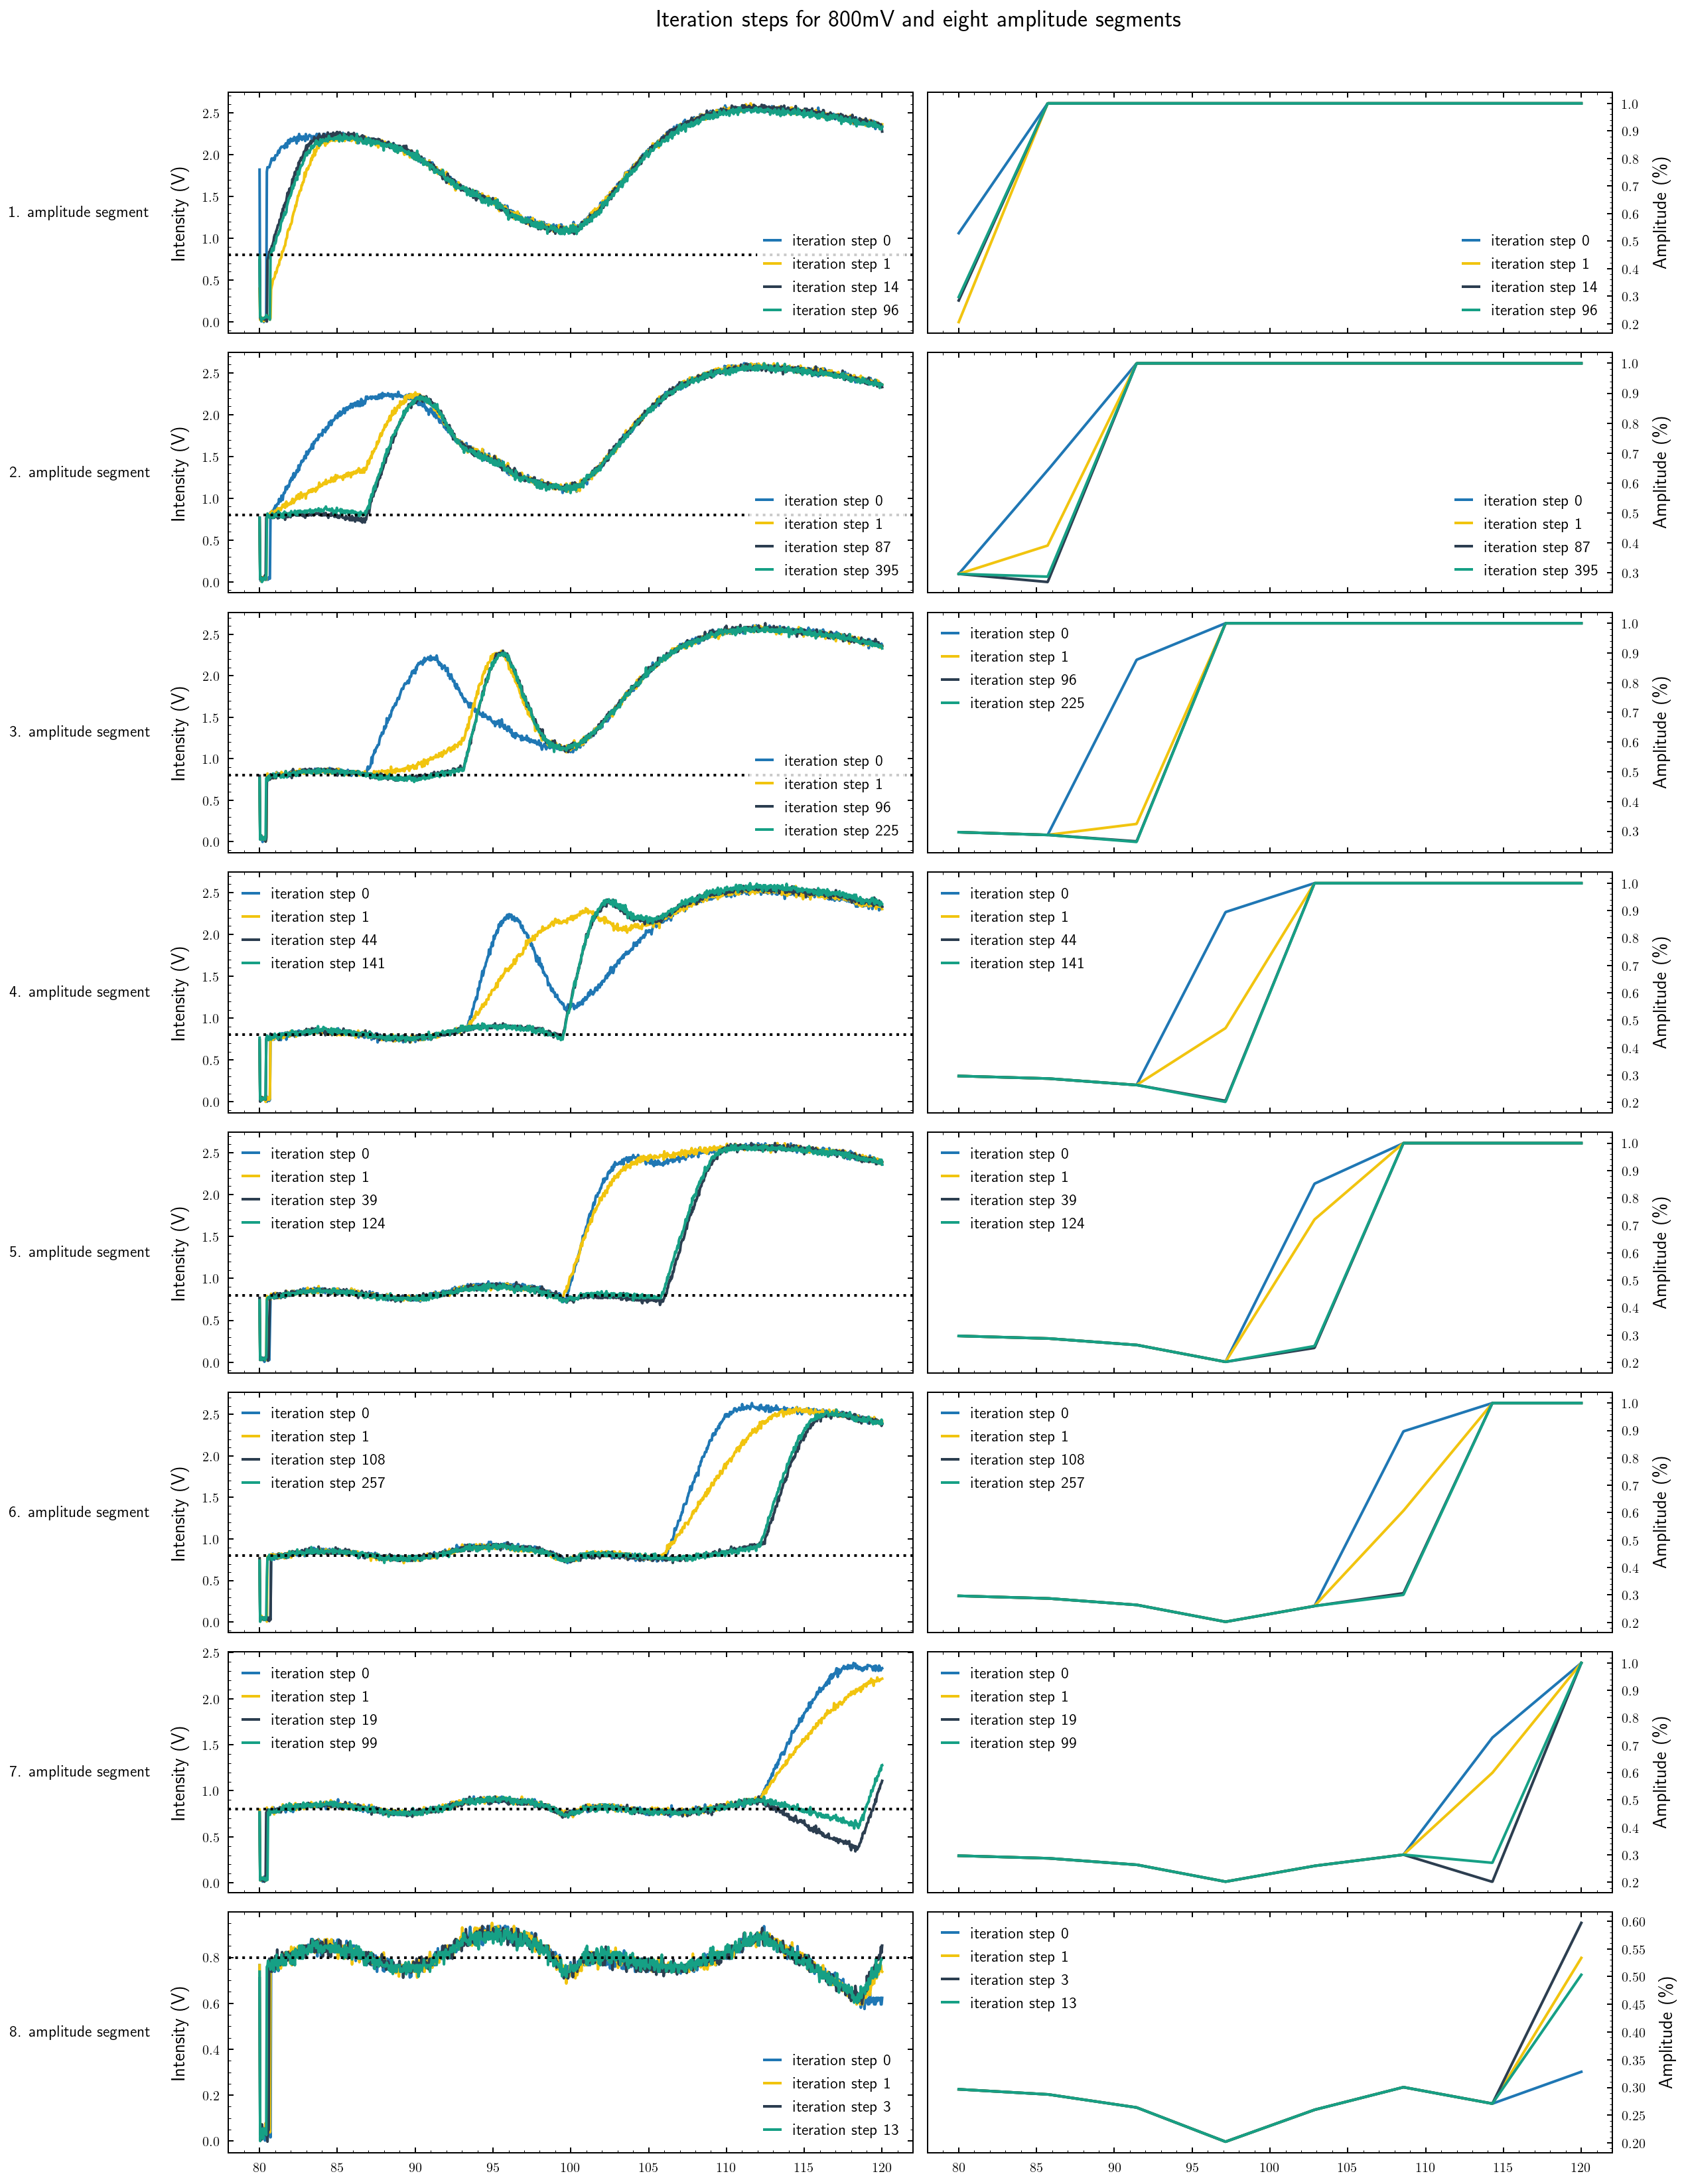

In [169]:
fig, axes = plt.subplots(ncols=2, nrows=8, figsize=(16, 24), sharex=True)

fig.suptitle('Iteration steps for 800mV and eight amplitude segments')

axes[0][0].plot(A0n0.frequency / 1e6, A0n0.voltage, label='iteration step 0')
axes[0][0].plot(A0n1.frequency / 1e6, A0n1.voltage, label='iteration step 1', color='#f1c40f')
axes[0][0].plot(A0n14.frequency / 1e6, A0n14.voltage, label='iteration step 14', color='#2c3e50')
axes[0][0].plot(A0n96.frequency / 1e6, A0n96.voltage, label='iteration step 96', color='#16a085')
axes[0][0].set_ylabel('Intensity (V)')
axes[0][0].axhline(.8, color='black', linestyle='dotted')
axes[0][0].legend()

axes[0][1].plot(A0n0.frequency / 1e6, A0n0.amplitude, label='iteration step 0')
axes[0][1].plot(A0n1.frequency / 1e6, A0n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[0][1].plot(A0n14.frequency / 1e6, A0n14.amplitude, label='iteration step 14', color='#2c3e50')
axes[0][1].plot(A0n96.frequency / 1e6, A0n96.amplitude, label='iteration step 96', color='#16a085')
axes[0][1].yaxis.tick_right()
axes[0][1].yaxis.set_label_position("right")
axes[0][1].set_ylabel('Amplitude (\%)')
axes[0][1].legend()

axes[1][0].plot(A1n0.frequency / 1e6, A1n0.voltage, label='iteration step 0')
axes[1][0].plot(A1n1.frequency / 1e6, A1n1.voltage, label='iteration step 1', color='#f1c40f')
axes[1][0].plot(A1n87.frequency / 1e6, A1n87.voltage, label='iteration step 87', color='#2c3e50')
axes[1][0].plot(A1n395.frequency / 1e6, A1n395.voltage, label='iteration step 395', color='#16a085')
axes[1][0].set_ylabel('Intensity (V)')
axes[1][0].axhline(.8, color='black', linestyle='dotted')
axes[1][0].legend()

axes[1][1].plot(A1n0.frequency / 1e6, A1n0.amplitude, label='iteration step 0')
axes[1][1].plot(A1n1.frequency / 1e6, A1n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[1][1].plot(A1n87.frequency / 1e6, A1n87.amplitude, label='iteration step 87', color='#2c3e50')
axes[1][1].plot(A1n395.frequency / 1e6, A1n395.amplitude, label='iteration step 395', color='#16a085')
axes[1][1].yaxis.tick_right()
axes[1][1].yaxis.set_label_position("right")
axes[1][1].set_ylabel('Amplitude (\%)')
axes[1][1].legend()

axes[2][0].plot(A2n0.frequency / 1e6, A2n0.voltage, label='iteration step 0')
axes[2][0].plot(A2n1.frequency / 1e6, A2n1.voltage, label='iteration step 1', color='#f1c40f')
axes[2][0].plot(A2n96.frequency / 1e6, A2n96.voltage, label='iteration step 96', color='#2c3e50')
axes[2][0].plot(A2n225.frequency / 1e6, A2n225.voltage, label='iteration step 225', color='#16a085')
axes[2][0].set_ylabel('Intensity (V)')
axes[2][0].axhline(.8, color='black', linestyle='dotted')
axes[2][0].legend()

axes[2][1].plot(A2n0.frequency / 1e6, A2n0.amplitude, label='iteration step 0')
axes[2][1].plot(A2n1.frequency / 1e6, A2n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[2][1].plot(A2n96.frequency / 1e6, A2n96.amplitude, label='iteration step 96', color='#2c3e50')
axes[2][1].plot(A2n225.frequency / 1e6, A2n225.amplitude, label='iteration step 225', color='#16a085')
axes[2][1].yaxis.tick_right()
axes[2][1].yaxis.set_label_position("right")
axes[2][1].set_ylabel('Amplitude (\%)')
axes[2][1].legend()

axes[3][0].plot(A3n0.frequency / 1e6, A3n0.voltage, label='iteration step 0')
axes[3][0].plot(A3n1.frequency / 1e6, A3n1.voltage, label='iteration step 1', color='#f1c40f')
axes[3][0].plot(A3n44.frequency / 1e6, A3n44.voltage, label='iteration step 44', color='#2c3e50')
axes[3][0].plot(A3n151.frequency / 1e6, A3n151.voltage, label='iteration step 141', color='#16a085')
axes[3][0].set_ylabel('Intensity (V)')
axes[3][0].axhline(.8, color='black', linestyle='dotted')
axes[3][0].legend()

axes[3][1].plot(A3n0.frequency / 1e6, A3n0.amplitude, label='iteration step 0')
axes[3][1].plot(A3n1.frequency / 1e6, A3n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[3][1].plot(A3n44.frequency / 1e6, A3n44.amplitude, label='iteration step 44', color='#2c3e50')
axes[3][1].plot(A3n151.frequency / 1e6, A3n151.amplitude, label='iteration step 141', color='#16a085')
axes[3][1].yaxis.tick_right()
axes[3][1].yaxis.set_label_position("right")
axes[3][1].set_ylabel('Amplitude (\%)')
axes[3][1].legend()

axes[4][0].plot(A4n0.frequency / 1e6, A4n0.voltage, label='iteration step 0')
axes[4][0].plot(A4n1.frequency / 1e6, A4n1.voltage, label='iteration step 1', color='#f1c40f')
axes[4][0].plot(A4n39.frequency / 1e6, A4n39.voltage, label='iteration step 39', color='#2c3e50')
axes[4][0].plot(A4n124.frequency / 1e6, A4n124.voltage, label='iteration step 124', color='#16a085')
axes[4][0].set_ylabel('Intensity (V)')
axes[4][0].axhline(.8, color='black', linestyle='dotted')
axes[4][0].legend()

axes[4][1].plot(A4n0.frequency / 1e6, A4n0.amplitude, label='iteration step 0')
axes[4][1].plot(A4n1.frequency / 1e6, A4n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[4][1].plot(A4n39.frequency / 1e6, A4n39.amplitude, label='iteration step 39', color='#2c3e50')
axes[4][1].plot(A4n124.frequency / 1e6, A4n124.amplitude, label='iteration step 124', color='#16a085')
axes[4][1].yaxis.tick_right()
axes[4][1].yaxis.set_label_position("right")
axes[4][1].set_ylabel('Amplitude (\%)')
axes[4][1].legend()

axes[5][0].plot(A5n0.frequency / 1e6, A5n0.voltage, label='iteration step 0')
axes[5][0].plot(A5n1.frequency / 1e6, A5n1.voltage, label='iteration step 1', color='#f1c40f')
axes[5][0].plot(A5n108.frequency / 1e6, A5n108.voltage, label='iteration step 108', color='#2c3e50')
axes[5][0].plot(A5n257.frequency / 1e6, A5n257.voltage, label='iteration step 257', color='#16a085')
axes[5][0].set_ylabel('Intensity (V)')
axes[5][0].axhline(.8, color='black', linestyle='dotted')
axes[5][0].legend()

axes[5][1].plot(A5n0.frequency / 1e6, A5n0.amplitude, label='iteration step 0')
axes[5][1].plot(A5n1.frequency / 1e6, A5n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[5][1].plot(A5n108.frequency / 1e6, A5n108.amplitude, label='iteration step 108', color='#2c3e50')
axes[5][1].plot(A5n257.frequency / 1e6, A5n257.amplitude, label='iteration step 257', color='#16a085')
axes[5][1].yaxis.tick_right()
axes[5][1].yaxis.set_label_position("right")
axes[5][1].set_ylabel('Amplitude (\%)')
axes[5][1].legend()

axes[6][0].plot(A6n0.frequency / 1e6, A6n0.voltage, label='iteration step 0')
axes[6][0].plot(A6n1.frequency / 1e6, A6n1.voltage, label='iteration step 1', color='#f1c40f')
axes[6][0].plot(A6n19.frequency / 1e6, A6n19.voltage, label='iteration step 19', color='#2c3e50')
axes[6][0].plot(A6n99.frequency / 1e6, A6n99.voltage, label='iteration step 99', color='#16a085')
axes[6][0].set_ylabel('Intensity (V)')
axes[6][0].axhline(.8, color='black', linestyle='dotted')
axes[6][0].legend()

axes[6][1].plot(A6n0.frequency / 1e6, A6n0.amplitude, label='iteration step 0')
axes[6][1].plot(A6n1.frequency / 1e6, A6n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[6][1].plot(A6n19.frequency / 1e6, A6n19.amplitude, label='iteration step 19', color='#2c3e50')
axes[6][1].plot(A6n99.frequency / 1e6, A6n99.amplitude, label='iteration step 99', color='#16a085')
axes[6][1].yaxis.tick_right()
axes[6][1].yaxis.set_label_position("right")
axes[6][1].set_ylabel('Amplitude (\%)')
axes[6][1].legend()

axes[7][0].plot(A7n0.frequency / 1e6, A7n0.voltage, label='iteration step 0')
axes[7][0].plot(A7n1.frequency / 1e6, A7n1.voltage, label='iteration step 1', color='#f1c40f')
axes[7][0].plot(A7n3.frequency / 1e6, A7n3.voltage, label='iteration step 3', color='#2c3e50')
axes[7][0].plot(A7n13.frequency / 1e6, A7n13.voltage, label='iteration step 13', color='#16a085')
axes[7][0].set_ylabel('Intensity (V)')
axes[7][0].axhline(.8, color='black', linestyle='dotted')
axes[7][0].legend()

axes[7][1].plot(A7n0.frequency / 1e6, A7n0.amplitude, label='iteration step 0')
axes[7][1].plot(A7n1.frequency / 1e6, A7n1.amplitude, label='iteration step 1', color='#f1c40f')
axes[7][1].plot(A7n3.frequency / 1e6, A7n3.amplitude, label='iteration step 3', color='#2c3e50')
axes[7][1].plot(A7n13.frequency / 1e6, A7n13.amplitude, label='iteration step 13', color='#16a085')
axes[7][1].yaxis.tick_right()
axes[7][1].yaxis.set_label_position("right")
axes[7][1].set_ylabel('Amplitude (\%)')
axes[7][1].legend()

pad = 5
rows = [f'{i}. amplitude segment' for i in range(1, 9)]

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(os.path.join(figuredir, 'process.pdf'))
plt.show()

In [143]:
runs['800mV-32']

{0: [0, 1, 26, 3, 43, 7, 9],
 1: [0, 10, 115, 17, 2, 43, 5],
 10: [0, 31, 32, 99],
 11: [0, 1, 182],
 12: [0, 16, 4, 58],
 13: [0, 1, 2, 4],
 14: [0, 1, 138, 29, 292, 35, 454, 8, 9],
 15: [0, 61],
 16: [0, 365, 403, 72, 8],
 17: [0, 1, 10, 114, 175, 2, 485, 73],
 18: [0, 1, 13, 5],
 19: [0, 155, 201, 206, 21, 317, 32, 39, 45, 489, 60, 94],
 2: [0, 12, 158, 3],
 20: [0, 16, 5],
 21: [0, 1, 114, 134, 152, 195, 277, 316, 393, 399, 41, 54, 84, 9],
 22: [0, 1, 18, 23, 240, 26, 4, 64, 7],
 23: [0, 146, 166, 276, 297, 31, 35, 435],
 24: [0, 1, 134, 143, 19, 20, 270, 4],
 25: [0, 118, 2],
 26: [0, 113, 119, 2, 31, 38, 5, 59, 6, 84, 89],
 27: [0, 13, 23, 6, 9],
 28: [0, 1, 10, 121, 2, 215, 268, 273, 282, 283, 3, 308, 341, 365, 368, 4],
 29: [0, 1, 10, 11, 12, 194, 38, 63],
 3: [0, 1, 122, 5, 6],
 30: [0, 13, 3, 420, 5, 93],
 31: [0, 1, 104, 3, 313, 466],
 4: [0, 1, 3, 71, 97],
 5: [0, 73],
 6: [0, 13, 159, 17, 2, 302, 34],
 7: [0, 1, 176, 18, 212, 215, 216, 228, 28, 303, 6, 85, 94],
 8: [0, 1, 

In [166]:
B0n0 = read('800mV-32.h5', 'amplitude0/iteration0')
B0n1 = read('800mV-32.h5', 'amplitude0/iteration1')
B0n26 = read('800mV-32.h5', 'amplitude0/iteration26')
B0n43 = read('800mV-32.h5', 'amplitude0/iteration43')

B2n0 = read('800mV-32.h5', 'amplitude2/iteration0')
B2n3 = read('800mV-32.h5', 'amplitude2/iteration3')
B2n12 = read('800mV-32.h5', 'amplitude2/iteration12')
B2n158 = read('800mV-32.h5', 'amplitude2/iteration158')

B4n0 = read('800mV-32.h5', 'amplitude4/iteration0')
B4n1 = read('800mV-32.h5', 'amplitude4/iteration1')
B4n3 = read('800mV-32.h5', 'amplitude4/iteration3')
B4n97 = read('800mV-32.h5', 'amplitude4/iteration97')

B5n0 = read('800mV-32.h5', 'amplitude5/iteration0')
B5n73 = read('800mV-32.h5', 'amplitude5/iteration73')

B6n0 = read('800mV-32.h5', 'amplitude6/iteration0')
B6n2 = read('800mV-32.h5', 'amplitude6/iteration2')
B6n17 = read('800mV-32.h5', 'amplitude6/iteration17')
B6n302 = read('800mV-32.h5', 'amplitude6/iteration302')

B8n0 = read('800mV-32.h5', 'amplitude8/iteration0')
B8n1 = read('800mV-32.h5', 'amplitude8/iteration1')
B8n7 = read('800mV-32.h5', 'amplitude8/iteration7')

B10n0 = read('800mV-32.h5', 'amplitude10/iteration0')
B10n31 = read('800mV-32.h5', 'amplitude10/iteration31')
B10n32 = read('800mV-32.h5', 'amplitude10/iteration32')
B10n99 = read('800mV-32.h5', 'amplitude10/iteration99')

B20n0 = read('800mV-32.h5', 'amplitude20/iteration0')
B20n5 = read('800mV-32.h5', 'amplitude20/iteration5')
B20n16 = read('800mV-32.h5', 'amplitude20/iteration16')

B30n0 = read('800mV-32.h5', 'amplitude30/iteration0')
B30n3 = read('800mV-32.h5', 'amplitude30/iteration3')
B30n420 = read('800mV-32.h5', 'amplitude30/iteration420')

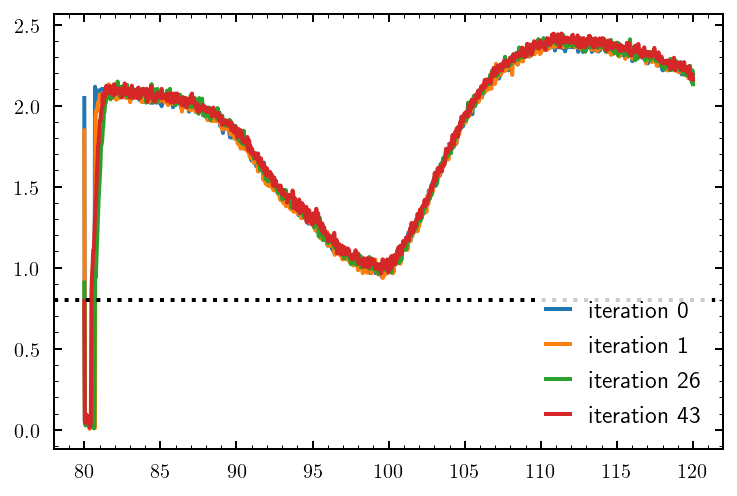

In [158]:
plt.plot(B0n0.frequency / 1e6, B0n0.voltage, label='iteration 0')
plt.plot(B0n1.frequency / 1e6, B0n1.voltage, label='iteration 1')
plt.plot(B0n26.frequency / 1e6, B0n26.voltage, label='iteration 26')
plt.plot(B0n43.frequency / 1e6, B0n43.voltage, label='iteration 43')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

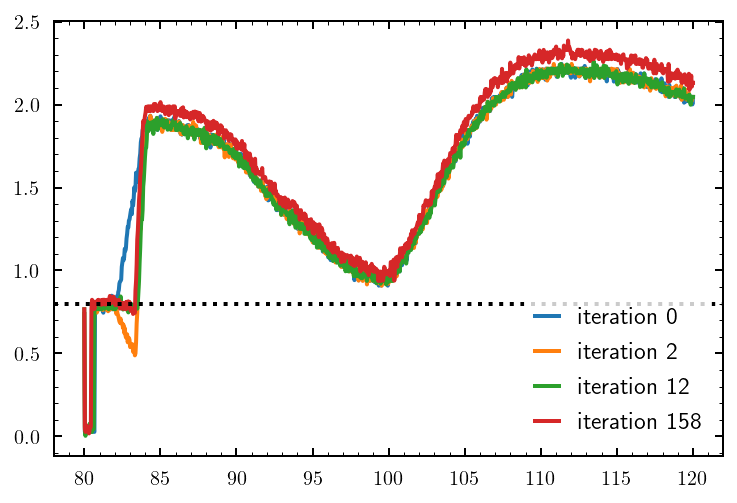

In [159]:
plt.plot(B2n0.frequency / 1e6, B2n0.voltage, label='iteration 0')
plt.plot(B2n3.frequency / 1e6, B2n3.voltage, label='iteration 2')
plt.plot(B2n12.frequency / 1e6, B2n12.voltage, label='iteration 12')
plt.plot(B2n158.frequency / 1e6, B2n158.voltage, label='iteration 158')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

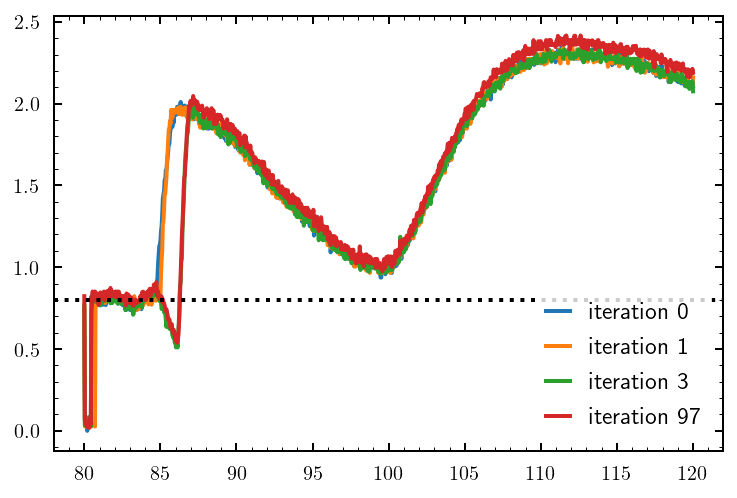

In [164]:
plt.plot(B4n0.frequency / 1e6, B4n0.voltage, label='iteration 0')
plt.plot(B4n1.frequency / 1e6, B4n1.voltage, label='iteration 1')
plt.plot(B4n3.frequency / 1e6, B4n3.voltage, label='iteration 3')
plt.plot(B4n97.frequency / 1e6, B4n97.voltage, label='iteration 97')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

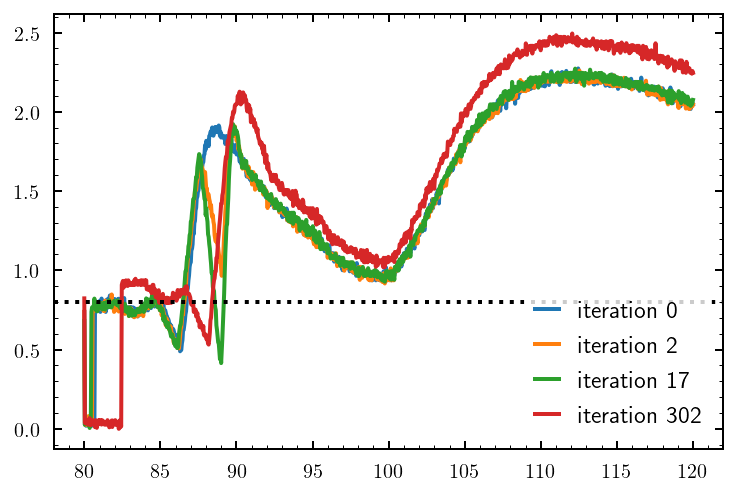

In [165]:
plt.plot(B6n0.frequency / 1e6, B6n0.voltage, label='iteration 0')
plt.plot(B6n2.frequency / 1e6, B6n2.voltage, label='iteration 2')
plt.plot(B6n17.frequency / 1e6, B6n17.voltage, label='iteration 17')
plt.plot(B6n302.frequency / 1e6, B6n302.voltage, label='iteration 302')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

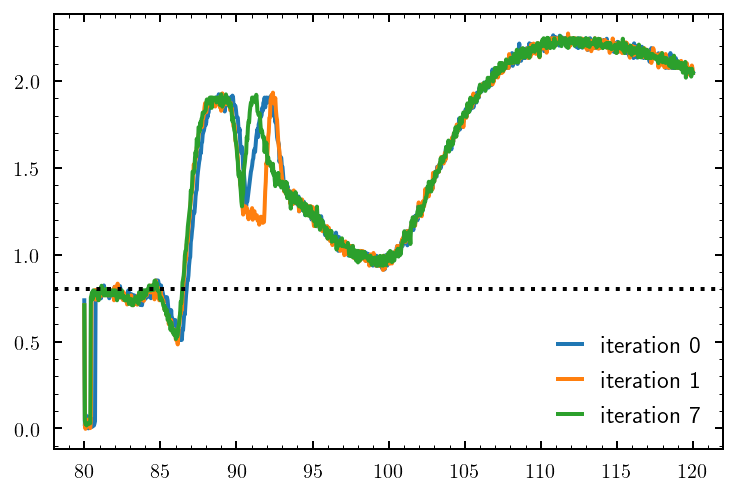

In [167]:
plt.plot(B8n0.frequency / 1e6, B8n0.voltage, label='iteration 0')
plt.plot(B8n1.frequency / 1e6, B8n1.voltage, label='iteration 1')
plt.plot(B8n7.frequency / 1e6, B8n7.voltage, label='iteration 7')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

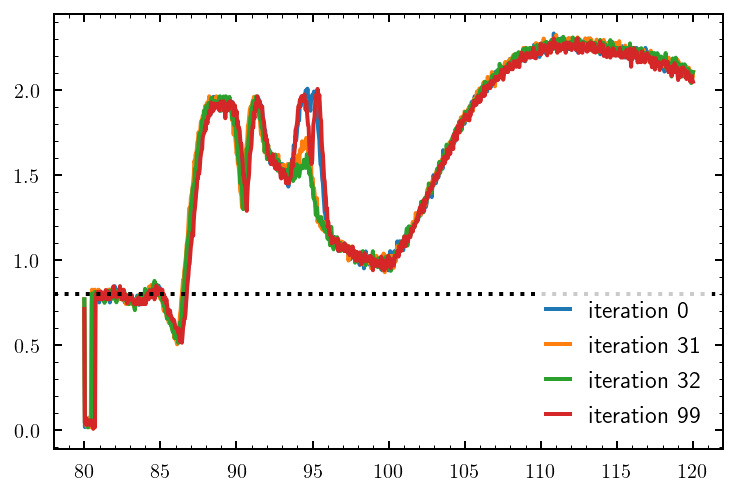

In [161]:
plt.plot(B10n0.frequency / 1e6, B10n0.voltage, label='iteration 0')
plt.plot(B10n31.frequency / 1e6, B10n31.voltage, label='iteration 31')
plt.plot(B10n32.frequency / 1e6, B10n32.voltage, label='iteration 32')
plt.plot(B10n99.frequency / 1e6, B10n99.voltage, label='iteration 99')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

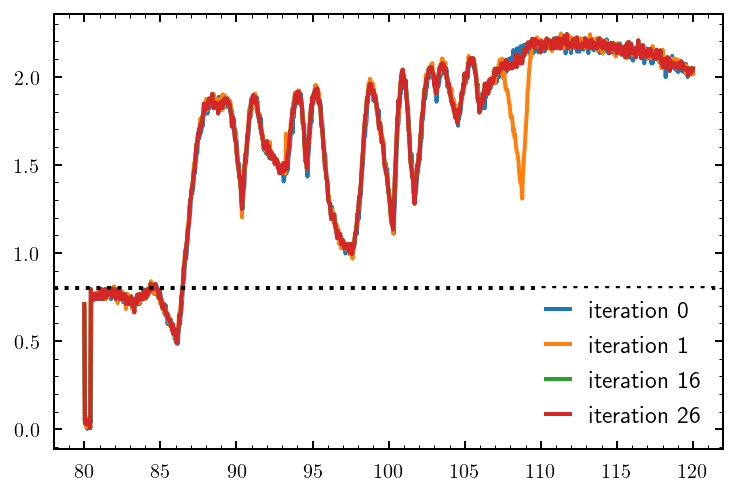

In [168]:
plt.plot(B20n0.frequency / 1e6, B20n0.voltage, label='iteration 0')
plt.plot(B20n1.frequency / 1e6, B20n1.voltage, label='iteration 1')
plt.plot(B20n16.frequency / 1e6, B20n16.voltage, label='iteration 16')
plt.plot(B20n26.frequency / 1e6, B20n26.voltage, label='iteration 26')
plt.axhline(.8, color='black', linestyle='dotted')
plt.legend()
plt.show()

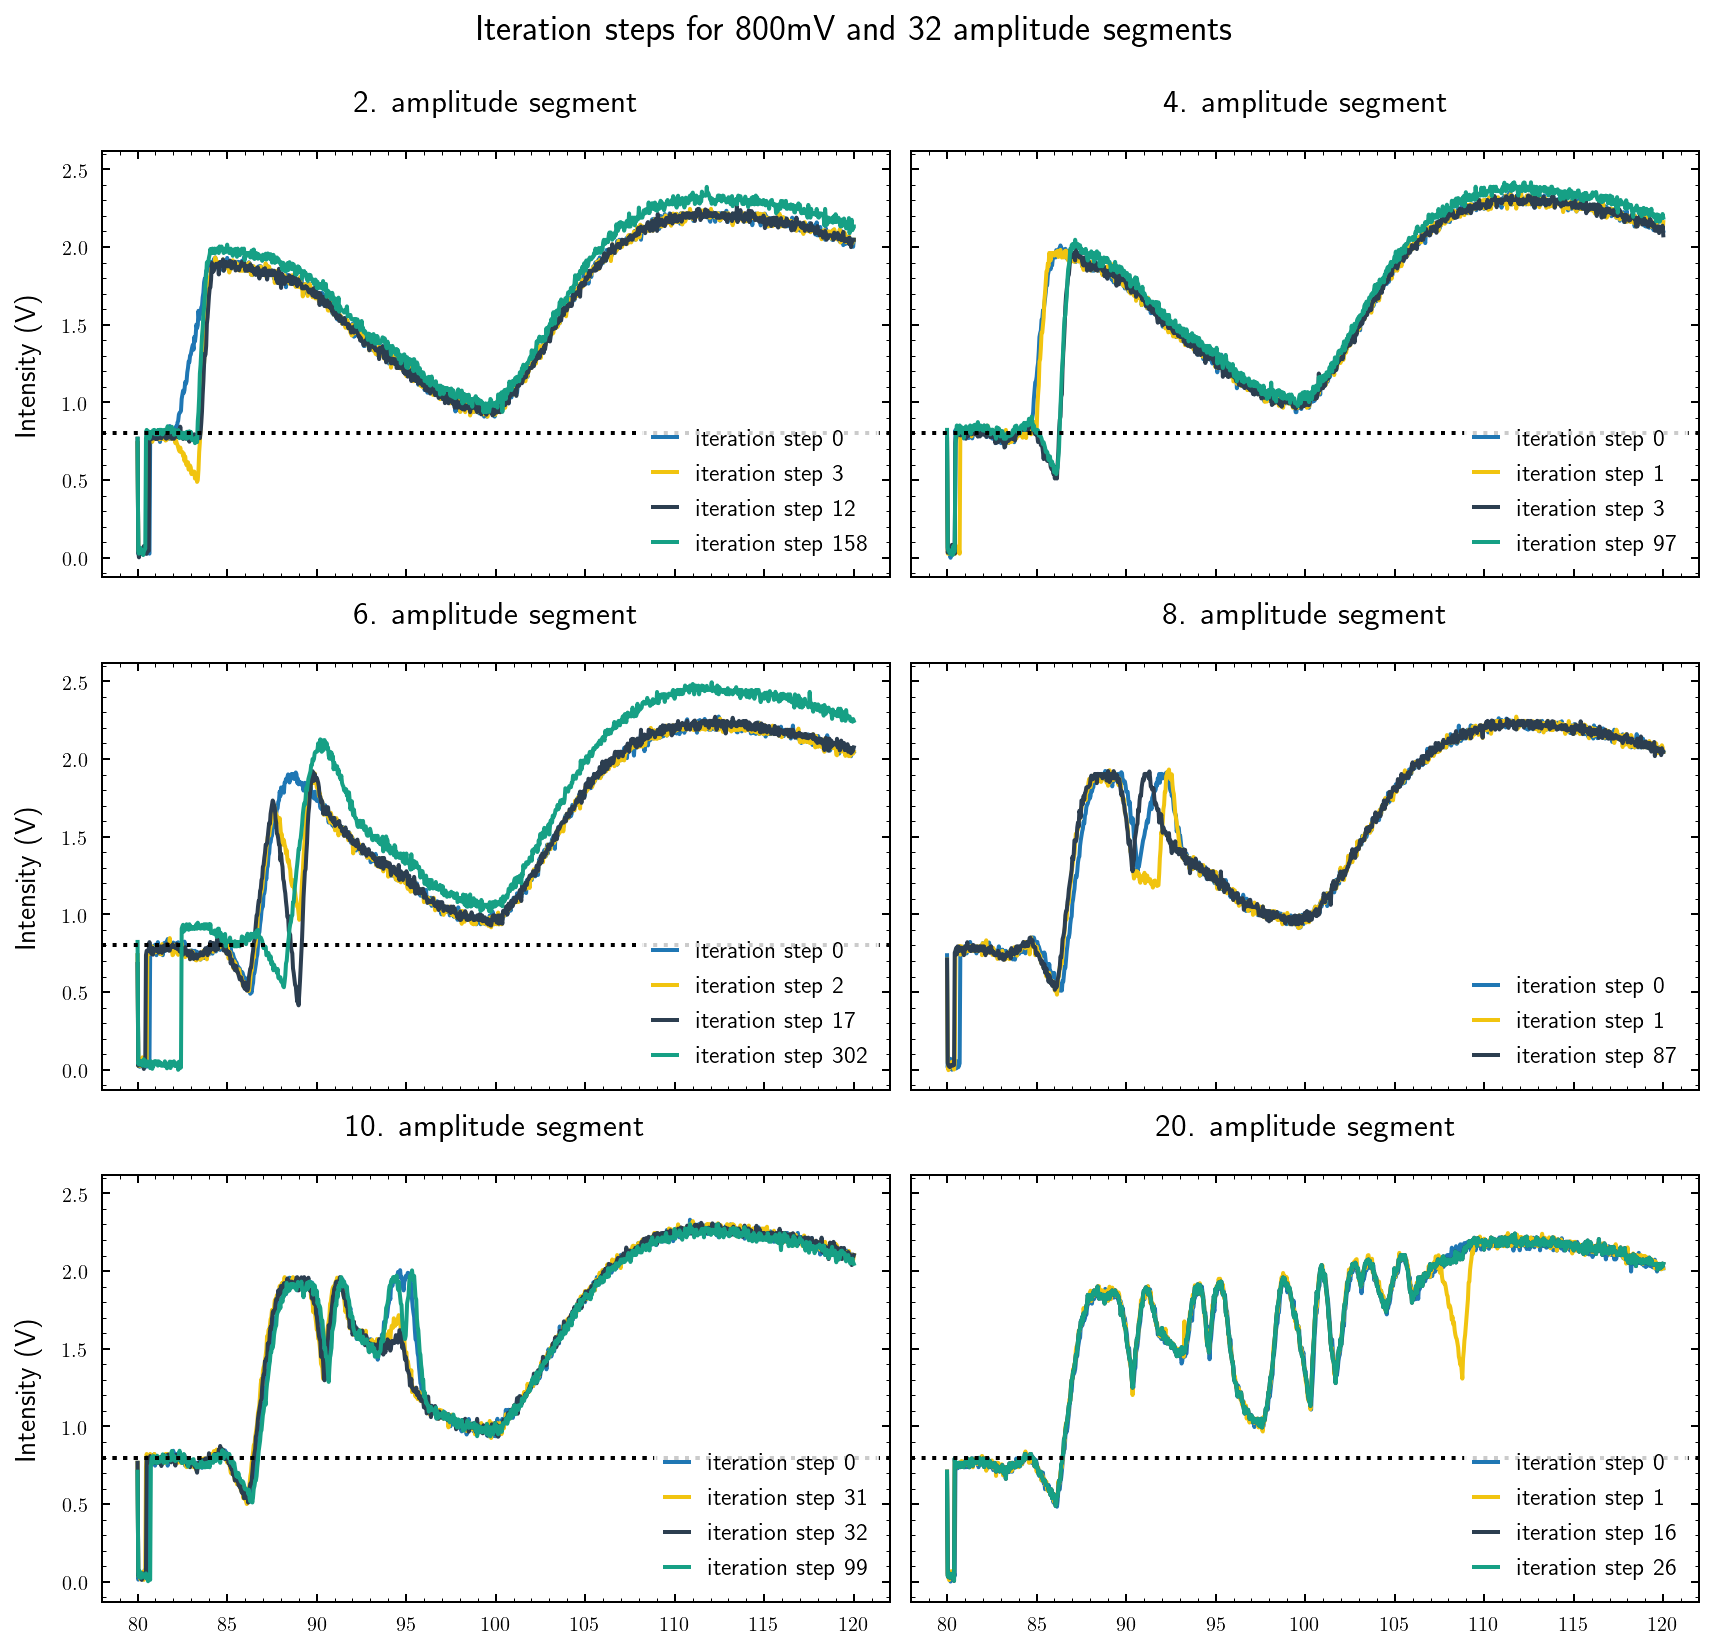

In [175]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex=True, sharey=True)

fig.suptitle('Iteration steps for 800mV and 32 amplitude segments')

axes[0][0].set_title('2. amplitude segment')
axes[0][0].plot(B2n0.frequency / 1e6, B2n0.voltage, label='iteration step 0')
axes[0][0].plot(B2n3.frequency / 1e6, B2n3.voltage, label='iteration step 3', color='#f1c40f')
axes[0][0].plot(B2n12.frequency / 1e6, B2n12.voltage, label='iteration step 12', color='#2c3e50')
axes[0][0].plot(B2n158.frequency / 1e6, B2n158.voltage, label='iteration step 158', color='#16a085')
axes[0][0].set_ylabel('Intensity (V)')
axes[0][0].axhline(.8, color='black', linestyle='dotted')
axes[0][0].legend()

axes[0][1].set_title('4. amplitude segment')
axes[0][1].plot(B4n0.frequency / 1e6, B4n0.voltage, label='iteration step 0')
axes[0][1].plot(B4n1.frequency / 1e6, B4n1.voltage, label='iteration step 1', color='#f1c40f')
axes[0][1].plot(B4n3.frequency / 1e6, B4n3.voltage, label='iteration step 3', color='#2c3e50')
axes[0][1].plot(B4n97.frequency / 1e6, B4n97.voltage, label='iteration step 97', color='#16a085')
axes[0][1].axhline(.8, color='black', linestyle='dotted')
axes[0][1].legend()

axes[1][0].set_title('6. amplitude segment')
axes[1][0].plot(B6n0.frequency / 1e6, B6n0.voltage, label='iteration step 0')
axes[1][0].plot(B6n2.frequency / 1e6, B6n2.voltage, label='iteration step 2', color='#f1c40f')
axes[1][0].plot(B6n17.frequency / 1e6, B6n17.voltage, label='iteration step 17', color='#2c3e50')
axes[1][0].plot(B6n302.frequency / 1e6, B6n302.voltage, label='iteration step 302', color='#16a085')
axes[1][0].set_ylabel('Intensity (V)')
axes[1][0].axhline(.8, color='black', linestyle='dotted')
axes[1][0].legend()

axes[1][1].set_title('8. amplitude segment')
axes[1][1].plot(B8n0.frequency / 1e6, B8n0.voltage, label='iteration step 0')
axes[1][1].plot(B8n1.frequency / 1e6, B8n1.voltage, label='iteration step 1', color='#f1c40f')
axes[1][1].plot(B8n7.frequency / 1e6, B8n7.voltage, label='iteration step 87', color='#2c3e50')
axes[2][0].axhline(.8, color='black', linestyle='dotted')
axes[1][1].legend()

axes[2][0].set_title('10. amplitude segment')
axes[2][0].plot(B10n0.frequency / 1e6, B10n0.voltage, label='iteration step 0')
axes[2][0].plot(B10n31.frequency / 1e6, B10n31.voltage, label='iteration step 31', color='#f1c40f')
axes[2][0].plot(B10n32.frequency / 1e6, B10n32.voltage, label='iteration step 32', color='#2c3e50')
axes[2][0].plot(B10n99.frequency / 1e6, B10n99.voltage, label='iteration step 99', color='#16a085')
axes[2][0].set_ylabel('Intensity (V)')
axes[2][0].axhline(.8, color='black', linestyle='dotted')
axes[2][0].legend()

axes[2][1].set_title('20. amplitude segment')
axes[2][1].plot(B20n0.frequency / 1e6, B20n0.voltage, label='iteration step 0')
axes[2][1].plot(B20n1.frequency / 1e6, B20n1.voltage, label='iteration step 1', color='#f1c40f')
axes[2][1].plot(B20n16.frequency / 1e6, B20n16.voltage, label='iteration step 16', color='#2c3e50')
axes[2][1].plot(B20n26.frequency / 1e6, B20n26.voltage, label='iteration step 26', color='#16a085')
axes[2][1].axhline(.8, color='black', linestyle='dotted')
axes[2][1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(os.path.join(figuredir, 'failure.pdf'))
plt.show()